## Molecular Solubility Prediction Through Graph Neural Networks


## Introduction 

*This project is undertaken as part of the course Graph Theory, focusing on the application of graph-based concepts to real world problems.*

Graph theory is a fundamental area of computer science and mathematics that allows us to model and analyze relation between entities. A graph represents a system as a set of vertices (nodes) connected by edges. It can be uused to decribe structures where interactions or connections are important as the individual components themselves. 

In computer science, graphs are primarily used to model networks such as the Internet, communication systems, dependency graphs in software engineering, and data structures like trees and directede acyclic graphs. In social netwokr analysis, individuals are represented as nodes and friendships, relationships or interactions are modelled as edge to study influence, information flow etc.



## Graph Based Learning For Chemical Structure Analysis

### Molecules and Their Structures

Molecules are composed of atoms arranged in specific spatial and bonding patterns that define their structure. The way atoms are connected determines the overall shape of a molecule, including features such as chains, rings and functional groups. These structural arrangements play a fundamental role in how molecules behave and interact with their environment.

### Dependence of Molecular Properties on Atoms and Bonds

The physical and chemical properties of a molecule are strongly influenced by the types of atoms it contains and the nature of bonds between them. Factors such as atomic composition, bond strength, bond type and connectivity affect properties like stability, reactivity, solubility and polarity.
Even small changes in bonding or atomic arrangements can lead to significant differences in molecular behavior.


### Relating Molecular Structures to Graphs

Molecular structures can be naturally represented using graphs, where atoms correspond to nodes and chemical bonds correspond to edges. This representation captures the connectivity of a molecule while abstracting away unecessary details, making it easier to analyze structrual patterns. Many concepts in chemistry, such as neighboring atoms, rings and branching , directly corresponds to graph theory concepts like adjacency, cycles and subgraphs.

### Graph Neural Networks (GNN)

Graph Neural Networks are a class of machine learning models designed to work directly with graph structured data. Unlike traditional models that operate on vectors or grids of fixed size, GNNs learn by exchanging information between connected nodes. This helps  to capture both local interactions and global structural pattersn present in the graph.

### Using GNNS to Learn From Structural Information

When applied to graph representation of molecules, GNNs can learn how atomic levbel interactions contribute to overall molecular behavior. By aggregating information from connected atoms and bonds, these models are able to form meaningful representations of molecular structures. This makes GNNs well-suited for predicting various molecular properties, as they can model the relationship between structure and function.


## Objective

In this project, graph-based learning is applied to the problem of predicting molecular solubility.

# The ESOL Dataset

The ESOL dataset , which stands for "Extended Solubility", is a dataset used for chemical informatics and machine learning for predicting solubility of chemical compounds.


The dataset contains information about solubility of various organic molecules in water.

- Graph Representation: Each chemical compound is represented as a graph where atoms are nodes, and chemical bonds are edges. This graph representation captures connectivity and structure of molecule

- Node features: The node feature vectors, in this case, typically represent the properties of individual atoms within the molecule. These features can include:
   - **Atom Type**: Each atom is assigned a specific atom type based on its element (e.g., carbon, hydrogen, oxygen, etc.). This is often one-hot encoded or represented as a categorical feature.

   - **Atomic Charges**: The partial charges on each atom, which describe the distribution of electric charge within the molecule.

   - **Hybridization**: Information about the hybridization state of each atom (e.g., sp3, sp2, sp).

   - **Atomic Mass**: The mass of each atom.

   - **Formal Charge**: The formal charge on each atom.

   - **Other Atom-specific Properties**: Depending on the specific implementation, additional atom-specific properties may also be included as node features.



3. **Edge Features**: In addition to node features, edge features can be included in the graph representation. These features typically describe the type of chemical bond between connected atoms (e.g., single, double, or triple bonds) and may also include bond distances or bond angles.

4. **Graph Structure**: The graph structure itself is represented by adjacency matrices or edge lists, which define how atoms are connected by chemical bonds.



In [1]:
from torch_geometric.datasets import MoleculeNet

DATA = MoleculeNet(".",name="ESOL")


/Users/ashi/Desktop/SOLGNN/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Processing...
Done!


In [2]:
print(f"Number of molecules: {len(DATA)}")



Number of molecules: 1128


In [3]:
## Looking at single molecule (GRAPH)

data = DATA[0]
print(data)


Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])


In [4]:
print("Dataset type: ", type(DATA))
print("Number of features per graph node: ", DATA.num_features)
print("Number of distinct target values (solubilities): ", DATA.num_classes)
print("Number of graphs: ", len(DATA))
print("Example graph: ", DATA[0])
print("Number of nodes in example graph: ", DATA[0].num_nodes)
print("Number of edges in example graph: ", DATA[0].num_edges)


Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Number of features per graph node:  9
Number of distinct target values (solubilities):  734
Number of graphs:  1128
Example graph:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
Number of nodes in example graph:  32
Number of edges in example graph:  68


/Users/ashi/Desktop/SOLGNN/.venv/lib/python3.14/site-packages/torch_geometric/data/in_memory_dataset.py:91: UserWarning: Found floating-point labels while calling `dataset.num_classes`. Returning the number of unique elements. Please make sure that this is expected before proceeding.
  return self._infer_num_classes(self._data.y)


In [5]:
# nodes of example graph 
DATA[0].x # shape: [num_nodes, num_node_features]

tensor([[8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 2, 5, 0, 0, 2, 0, 0],
        [7, 0, 1, 5, 0, 0, 2, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
        [8, 0, 2, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 1, 0, 4, 0, 1],
 

In [6]:
# edge attributes of example graph
DATA[0].edge_attr # shape [num_edges, num_edge_features]

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 3,  0,  0],
        [ 3,  0,  0],
        [ 1,  0,  0],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  0],
        [ 

In [7]:
DATA[0].y

tensor([[-0.7700]])

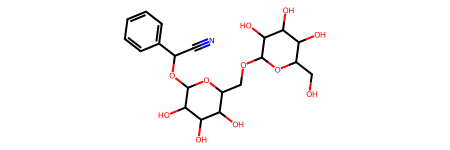

In [8]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

Chem.MolFromSmiles(DATA[0]["smiles"])

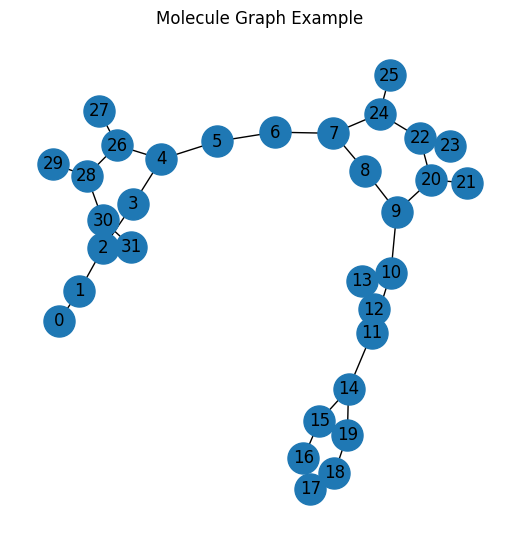

In [9]:
import networkx as nx 
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)

plt.figure(figsize=(5,5))
nx.draw(G, with_labels=True, node_size=500)
plt.title("Molecule Graph Example")
plt.show()


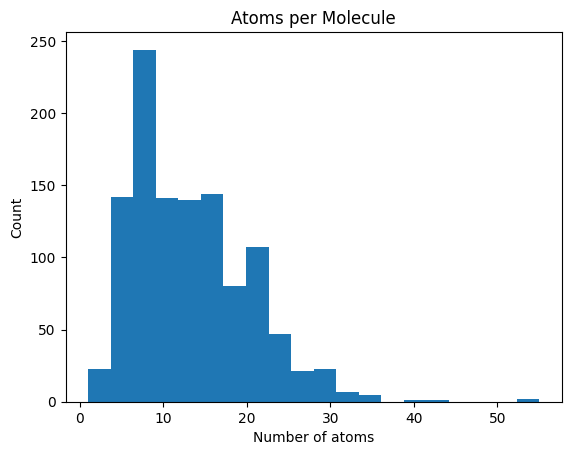

In [10]:
num_nodes = [d.num_nodes for d in DATA]

plt.hist(num_nodes, bins=20)
plt.xlabel("Number of atoms")
plt.ylabel("Count")
plt.title("Atoms per Molecule")
plt.show()


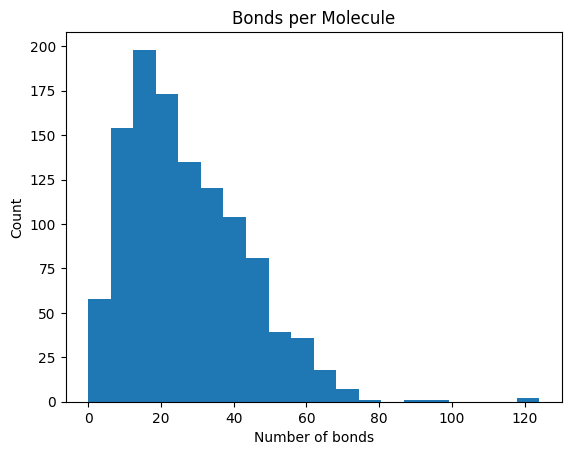

In [11]:
num_edges = [d.num_edges for d in DATA]

plt.hist(num_edges, bins=20)
plt.xlabel("Number of bonds")
plt.ylabel("Count")
plt.title("Bonds per Molecule")
plt.show()


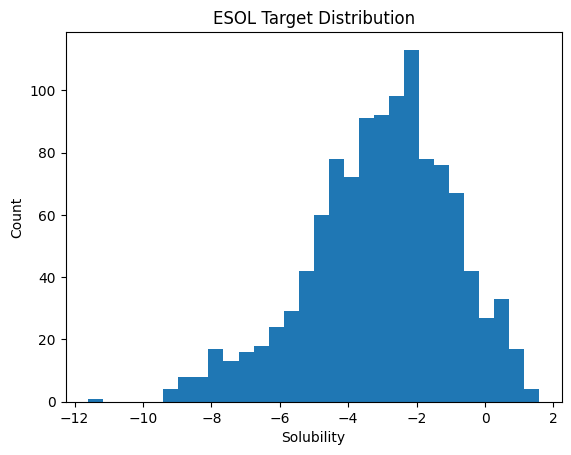

In [12]:

import numpy as np
import torch 
import matplotlib.pyplot as plt

y = torch.cat([d.y for d in DATA]).cpu().numpy()

plt.hist(y, bins=30)
plt.xlabel("Solubility")
plt.ylabel("Count")
plt.title("ESOL Target Distribution")
plt.show()


In [13]:
# GCNN

import torch 
from torch.nn import Linear 
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gp , global_max_pool as gmp 

EMBEDDING_DIMENSION = 64 


class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN,self).__init__()
    torch.manual_seed(67)
    self.initial_conv = GCNConv (
      in_channels=DATA.num_features,
      out_channels=EMBEDDING_DIMENSION
    )
    self.conv1 = GCNConv(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)
    self.conv2 = GCNConv(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)
    self.conv3 = GCNConv(EMBEDDING_DIMENSION,EMBEDDING_DIMENSION)

    self.out = Linear(
      in_features=EMBEDDING_DIMENSION * 2, 
      out_features=1
    )
   
  def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations over nodes of graph)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gp(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden


MODEL = GCN()
print(MODEL)
print("Number of parameters: ", sum(p.numel() for p in MODEL.parameters()))

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)
Number of parameters:  13249


In [ ]:
from torch_geometric.nn import NNConv,global_max_pool, global_add_pool
from torch.nn import BatchNorm1d, Linear, Dropout

class MolecularGCN_EdgeNet(torch.nn.Module):
  """
  Hybrid GCN + Edge Network for molecular property prediction. 
  Combines node features (atoms) with edge features (bonds) for better solubility prediction
  """

  def __init__(self, num_node_features, num_edge_features=None, embedding_dim=64,dropout=0.2):
    super(MolecularGCN_EdgeNet,self).__init__()
    torch.manual_seed(67)

    self.use_edge_features = num_edge_features is not None 
    
    self.node_encoder = Linear(num_node_features, embedding_dim)

    if self.use_edge_features:
      # Edge Network : Learns edge feature transformation
      edge_nn = torch.nn.Sequential(
        Linear(num_edge_features,embedding_dim * embedding_dim),
        torch.nn.ReLU(),
        Linear(embedding_dim*embedding_dim,embedding_dim*embedding_dim)
      )

      self.edge_conv1 = NNConv(embedding_dim,embedding_dim,edge_nn,aggr="mean")
      edge_nn2 = torch.nn.Sequential(
        Linear(num_edge_features,embedding_dim * embedding_dim),
        torch.nn.ReLU(),
        Linear(embedding_dim*embedding_dim,embedding_dim * embedding_dim)
      )
      self.edge_conv2 = NNConv(embedding_dim, embedding_dim, edge_nn2, aggr="mean")

      # GCN Layers for structure
      self.conv1 = GCNConv(embedding_dim, embedding_dim)
      self.conv2 = GCNConv(embedding_dim,embedding_dim)
      self.conv3 = GCNConv(embedding_dim,embedding_dim)

      # Batch Normalization for stable training

      self.bn1 = BatchNorm1d(embedding_dim)
      self.bn2 = BatchNorm1d(embedding_dim)
      self.bn3 = BatchNorm1d(embedding_dim)

        # Global pooling combines mean, max, and sum for comprehensive graph representation
      self.dropout = Dropout(dropout)
      pool_dim = embedding_dim * 3
       # MLP for final prediction
      self.fc1 = Linear(pool_dim, embedding_dim * 2)
      self.fc_bn = BatchNorm1d(embedding_dim * 2)
      self.fc2 = Linear(embedding_dim * 2, embedding_dim)
      self.out = Linear(embedding_dim, 1)

  def forward(self,x,edge_index,batch_index, edge_attr=None):

    x = self.node_encoder(x)
    x = F.relu(x)

    # Edge-aware convolutions if the edge featurres become avaiblae

    if self.use_edge_features and edge_attr is not None:
      x_edge = self.edge_conv1(x,edge_index,edge_attr)
      x_edge = self.bn1(x_edge)
      x_edge = F.relu(x_edge)
      x_edge = self.dropout(x_edge)
      x_edge = self.edge_conv2(x_edge,edge_index,edge_attr)
      x_edge = self.bn2(x_edge)
      x_edge = F.relu(x_edge)
    else:
      x_edge = x
        # Standard GCN convolutions
    x = self.conv1(x_edge, edge_index)
    x = self.bn1(x) if not self.use_edge_features else F.relu(x)
    x = F.relu(x) if self.use_edge_features else x
    x = self.dropout(x)
        
    x = self.conv2(x, edge_index)
    x = self.bn2(x) if not self.use_edge_features else self.bn3(x)
    x = F.relu(x)
    x = self.dropout(x)
        
    x = self.conv3(x, edge_index)
    x = self.bn3(x) if not self.use_edge_features else F.relu(x)
    x = F.relu(x) if self.use_edge_features else x
        
        # Multi-scale global pooling
        # Different pooling operations capture different aspects of molecular structure
    x_mean = global_mean_pool(x, batch_index)  # Average atom features
    x_max = global_max_pool(x, batch_index)     # Most prominent features
    x_sum = global_add_pool(x, batch_index)     # Size-dependent features
        
    x = torch.cat([x_mean, x_max, x_sum], dim=1)
        
        # MLP for final prediction
    x = self.fc1(x)
    x = self.fc_bn(x)
    x = F.relu(x)
    x = self.dropout(x)
        
    x = self.fc2(x)
    x = F.relu(x)
    x = self.dropout(x)
        
    out = self.out(x)
        
    return out, x





TypeError: MolecularGCN_EdgeNet.__init__() missing 1 required positional argument: 'num_node_features'

In [ ]:
# Initialize MolecularGCN_EdgeNet with correct input dimensions
num_node_features = DATA.num_features
num_edge_features = DATA[0].edge_attr.shape[1] if DATA[0].edge_attr is not None else None
EDGE_MODEL = MolecularGCN_EdgeNet(num_node_features=num_node_features, num_edge_features=num_edge_features)
print(EDGE_MODEL)

In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")
import torch

NUM_GRAPHS_PER_BATCH = 64

if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("APPLE MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")




# def train(model, data):
#   model = model.to(DEVICE)

#   loss_fn = torch.nn.MSELoss()

#   optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)

#   data_size = len(data)
#   train_loader = DataLoader(
#     data[:int(data_size * 0.8)], 
#     batch_size=NUM_GRAPHS_PER_BATCH, 
#     shuffle=True,
#   )

#   for batch in train_loader:
#     batch.to(DEVICE)  
#     # Reseting the gradients
#     optimizer.zero_grad() 
#     # Passing the node features and the edge info
#     pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 

#     loss = loss_fn(pred, batch.y)     
#     loss.backward()  
    
#     # Update  the gradients
#     optimizer.step()   
#   return loss, embedding

# def train_wrapper():
#   print("Starting training...")
#   losses = []
#   for epoch in range(2000): 
#       loss, h = train(MODEL, DATA)
#       losses.append(loss)
#       if epoch % 100 == 0: 
#         print(f"Epoch {epoch} | Train Loss {loss}")
#   return losses 

# LOSSES = train_wrapper() 


from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

NUM_GRAPHS_PER_BATCH = 64

def train_edge_model(model, data):
  model = model.to(DEVICE)
  
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
  
  data_size = len(data)
  train_loader = DataLoader(
    data[:int(data_size * 0.8)], 
    batch_size=NUM_GRAPHS_PER_BATCH, 
    shuffle=True,
  )
  
  for batch in train_loader:
    batch.to(DEVICE)  
    optimizer.zero_grad() 
    
    # Pass edge attributes to the model
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch, batch.edge_attr.float()) 
    
    loss = loss_fn(pred, batch.y)     
    loss.backward()  
    optimizer.step()   
    
  return loss, embedding

def train_edge_wrapper():
  print("Starting training with MolecularGCN_EdgeNet...")
  losses = []
  for epoch in range(2000): 
      loss, h = train_edge_model(EDGE_MODEL, DATA)
      losses.append(loss)
      if epoch % 100 == 0: 
        print(f"Epoch {epoch} | Train Loss {loss}")
  return losses 

EDGE_LOSSES = train_edge_wrapper()


/Users/ashi/Desktop/SOLGNN/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'torch' is not defined

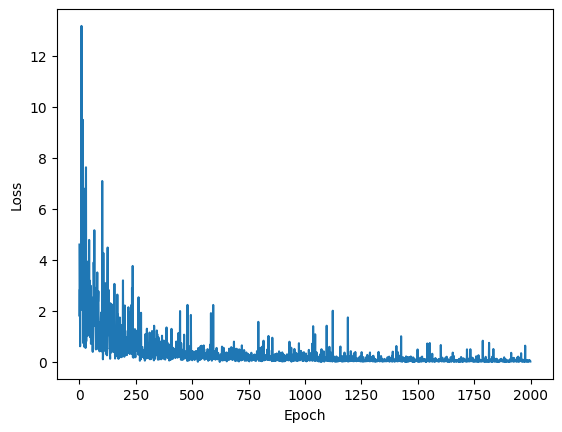

In [15]:
import seaborn as sns

def plot_train_loss(): 
  losses_float = [float(loss.cpu().detach().numpy()) for loss in LOSSES] 
  loss_indices = range(len(losses_float))
  ax = sns.lineplot(x=loss_indices, y=losses_float)
  ax.set(xlabel='Epoch', ylabel='Loss')
  
plot_train_loss()

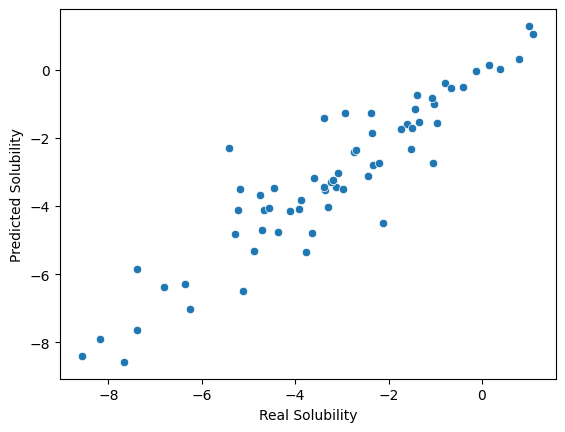

In [16]:
## Predicting

import pandas as pd 

def predict(model, data): 
  data_size = len(data)
  test_loader = DataLoader(
    data[int(data_size * 0.8):], 
    batch_size=NUM_GRAPHS_PER_BATCH, 
    shuffle=True
  )

  # Analyze the results for one batch
  test_batch = next(iter(test_loader))

  with torch.no_grad():
    test_batch.to(DEVICE)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()

  df["y_real"] = df["y_real"].apply(lambda row: row[0])
  df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

  axes = sns.scatterplot(data=df, x="y_real", y="y_pred")
  axes.set_xlabel("Real Solubility")
  axes.set_ylabel("Predicted Solubility")

predict(MODEL, DATA)